In [ ]:
import pandas as pd
import numpy as np
# import pymssql
# from fuzzywuzzy import fuzz
import json
import tweepy
from collections import defaultdict
from datetime import datetime
import re
# import pyodbc
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string, nltk, re, json, tweepy, gensim, scipy.sparse, pickle, pyLDAvis, pyLDAvis.gensim
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import matutils, models, corpora
import warnings
warnings.filterwarnings("ignore")

# Social Media Analysis

## EDA

In [ ]:
df = pd.read_csv('./meme_cleaning.csv')

In [ ]:
df_sentiment = pd.read_csv('563_df_sentiments.csv')

In [ ]:
df_sentiment = df_sentiment.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

In [ ]:
df_sentiment.head()

,Posted_By,Twitter_Handle,Tweet,Created_At,No_of_Likes,No_of_Retweets,No_of_Followers,User_Location,Image_URL,Labels,vaderSentimentScores,vaderSentiment
0,furry_irl,rFurry_Irl,Furry_irl | https://t.co/vPgHv1R6W6 #memes #fu...,3/6/21 7:13,0,0,501,NaN,http://pbs.twimg.com/media/Evx1QhLWYAArjHu.jpg,Sleeve Gesture Fawn Happy Adaptation Art Toy F...,0.5719,positive
1,SidenoteSuplex,SidenoteSuplex,The Speculation continues...#AEW #AEWRevolutio...,3/6/21 7:06,0,0,233,NaN,http://pbs.twimg.com/media/EvxzdHqXcAchlkN.jpg,Hair Head Shirt Product Blue Yellow Font T shi...,0.0000,neutral
2,FunnyThings,funny_things127,When you’re dead inside but your best friend n...,3/6/21 7:06,0,0,1508,NaN,http://pbs.twimg.com/media/EvxzubJXEAAd4_-.jpg,Petal Paint Plant Art Mythical creature Creati...,0.4404,positive
3,👁️🅰️🚗ℹ️💲,chic_aya,POV: Your black cat has a mid '9 lives' crisis...,3/6/21 7:03,1,0,138,NaN,http://pbs.twimg.com/tweet_video_thumb/Evxygjw...,Cat Vertebrate Tableware Window Carnivore Whis...,0.0000,neutral
4,Tell Tales Entertainment,TellTalesOnline,We hate being so savage🤭 #meme #memes #kimkard...,3/6/21 7:00,2,0,410,NaN,http://pbs.twimg.com/media/EvxyTy6WgAALDAb.png,Toilet seat Toilet Bathroom Purple Fluid House...,0.0000,neutral


In [ ]:
#Extract all words that begin with # and turn the results into a dataframe
temp = df_sentiment['Tweet'].str.lower().str.extractall(r"(#\w+)")
temp.columns = ['unnamed']
# Convert the multiple hashtag values into a list
temp = temp.groupby(level = 0)['unnamed'].apply(list)
# Save the result as a feature in the original dataset
df_sentiment['hashtags'] = temp

In [ ]:
for i in range(len(df_sentiment)):
    if df_sentiment.loc[i, 'No_of_Retweets'] >= 4:
        df_sentiment.loc[i, 'No_of_Retweets'] = 4

for i in range(len(df_sentiment)):
    if df_sentiment.loc[i, 'No_of_Likes'] >= 10:
        df_sentiment.loc[i, 'No_of_Likes'] = 10

In [ ]:
retweet_df = df_sentiment.groupby(['No_of_Retweets', 'vaderSentiment']).vaderSentimentScores.agg(count='count').reset_index()
like_df = df_sentiment.groupby(['No_of_Likes', 'vaderSentiment']).vaderSentimentScores.agg(count='count').reset_index()
classify_df = df_sentiment.vaderSentiment.value_counts().reset_index()
df_sentiment.Labels = df_sentiment.Labels.fillna('')

In [ ]:
df_likes_dict = df_sentiment.groupby('No_of_Likes').vaderSentimentScores.agg(count='count').to_dict()['count']
df_retweet_dict = df_sentiment.groupby('No_of_Retweets').vaderSentimentScores.agg(count='count').to_dict()['count']

In [ ]:
for i in range(len(like_df)):
  like_df.loc[i, 'Normalized_count'] = like_df.loc[i, 'count'] / df_likes_dict[like_df.loc[i, 'No_of_Likes']]

for i in range(len(retweet_df)):
  retweet_df.loc[i, 'Normalized_count'] = retweet_df.loc[i, 'count'] / df_retweet_dict[retweet_df.loc[i, 'No_of_Retweets']]

## Sentiment

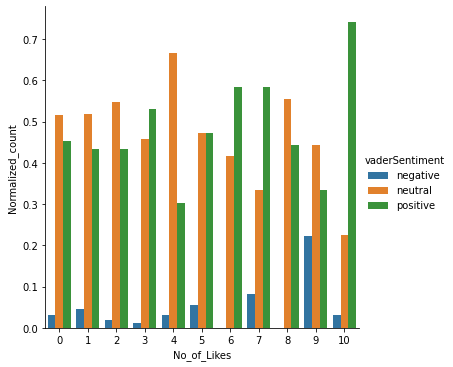

In [ ]:
g = sns.catplot(x = "No_of_Likes", y = "Normalized_count", hue = "vaderSentiment", data = like_df, kind = "bar")

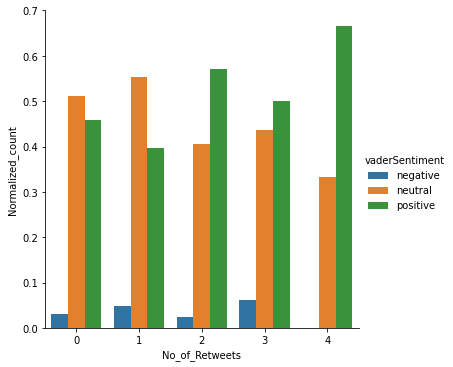

In [ ]:
g = sns.catplot(x = "No_of_Retweets", y = "Normalized_count", hue = "vaderSentiment", data = retweet_df, kind = "bar")

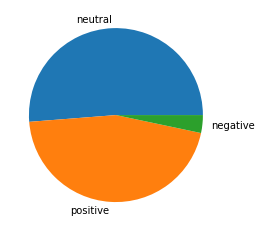

In [ ]:
plt.pie(classify_df['vaderSentiment'], labels=classify_df['index']);

In [ ]:
l = []
for i in range(len(df_sentiment)):
  for element in df_sentiment.loc[i, 'Labels'].split():
    if element != 'Font':
      l.append(element)

## Word Cloud

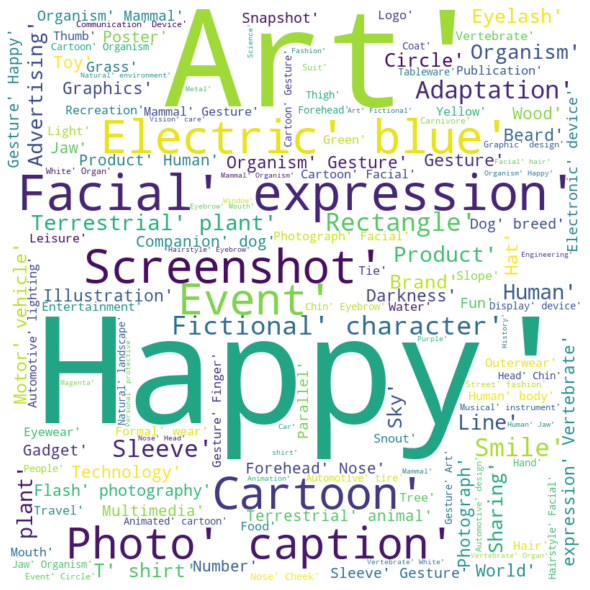

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(str(l))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

## Topic Modeling

In [ ]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(df.Tweet)
words = cv.get_feature_names()
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
pickle.dump(cv, open("cv_stop.pkl", "wb"))

In [ ]:
data_dtm_transpose = data_dtm.transpose()

In [ ]:
sparse_counts = scipy.sparse.csr_matrix(data_dtm_transpose)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [ ]:
cv = pickle.load(open("cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())
word2id = dict((k, v) for k, v in cv.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id

In [ ]:
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

[(0,
  '0.190*"meme" + 0.044*"memesdaily" + 0.032*"dankmemes" + 0.019*"furry" + 0.015*"funny" + 0.009*"leagueoflegends" + 0.007*"lol" + 0.006*"leagueoflegendsmemes" + 0.005*"furry_irl" + 0.004*"reddit"'),
 (1,
  '0.165*"meme" + 0.018*"reddit" + 0.016*"furry" + 0.015*"funny" + 0.010*"know" + 0.009*"dogecoin" + 0.009*"cryptosreelgooodmemes" + 0.007*"dnde" + 0.007*"dungeonsanddragons" + 0.007*"ttrpgs"'),
 (2,
  '0.122*"meme" + 0.015*"minecraft" + 0.013*"minecraftmemes" + 0.012*"like" + 0.007*"funny" + 0.006*"people" + 0.004*"reddit" + 0.004*"ah" + 0.004*"really" + 0.004*"start"')]

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, d)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.102552  0.059132       1        1  43.862589
1      0.003193 -0.113064       2        1  32.690584
2     -0.105745  0.053932       3        1  23.446826, topic_info=                Term        Freq       Total Category  logprob  loglift
38        memesdaily  143.000000  143.000000  Default  30.0000  30.0000
52         dankmemes  103.000000  103.000000  Default  29.0000  29.0000
382        minecraft   25.000000   25.000000  Default  28.0000  28.0000
383   minecraftmemes   22.000000   22.000000  Default  27.0000  27.0000
95              know   23.000000   23.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
958            music    3.951697    7.469557   Topic3  -6.0098   0.8137
41          dogecoin    5.809839   26.628318   Topic3  -5.6243  -0.0720
653           reddit    6.827258   59.709951   Topic3  -5.4630  -0.7181
77   leagueoflegends    4.943729   32.876919   Topic3  -5.7858  -0.4442
311             make    3.980762   10.579233   Topic3  -6.0024   0.4730

[172 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
140       3  0.951545           ah
1207      1  0.541165  auntysocial
1207      2  0.481036  auntysocial
1011      3  0.677722         away
212       3  0.677676      believe
...     ...       ...          ...
461       3  0.078148         work
380       1  0.911294          wtf
188       1  0.975562         year
451       2  0.246617          yes
451       3  0.739850          yes

[193 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])